In [102]:
""" Check if linear trend is implemented correctly.
-------------------------------------------------------------------------------

Author: Rutger Hofste
Date: 20180621
Kernel: python35
Docker: rutgerhofste/gisdocker:ubuntu16.04

Args:
    TESTING (Boolean) : Toggle testing case.
    SCRIPT_NAME (string) : Script name.
    OUTPUT_VERSION (integer) : output version.
    DATABASE_ENDPOINT (string) : RDS or postGreSQL endpoint.
    DATABASE_NAME (string) : Database name.
    TABLE_NAME_AREA_30SPFAF06 (string) : Table name used for areas. Must exist
        on same database as used in rest of script.
    S3_INPUT_PATH_RIVERDISCHARGE (string) : AWS S3 input path for 
        riverdischarge.    
    S3_INPUT_PATH_DEMAND (string) : AWS S3 input path for 
        demand.     

"""


OVERWRITE_OUTPUT = 1
SCRIPT_NAME = 'Y2018M06D21_RH_QA_Linear_Trend_PostGIS_V01'
OUTPUT_VERSION = 1

DATABASE_ENDPOINT = "aqueduct30v05.cgpnumwmfcqc.eu-central-1.rds.amazonaws.com"
DATABASE_NAME = "database01"

INPUT_TABLE_NAME = 'y2018m06d01_rh_temporal_reducers_postgis_30spfaf06_v01_v03'
OUTPUT_TABLE_NAME = SCRIPT_NAME.lower() + "_v{:02.0f}".format(OUTPUT_VERSION)
OUTPUT_SCHEMA_NAME = "test"

INPUT_TABLE_HYBAS = "hybas06_v04"

TEST_BASIN_PFAF_ID = 157650
MONTH = 12
TEMPORAL_RESOLUTION = "year"

print("Input Table: " , INPUT_TABLE_NAME, 
      "\nInout Table Hybas: ", INPUT_TABLE_HYBAS,
      "\nOutput Table: " , OUTPUT_TABLE_NAME)

Input Table:  y2018m06d01_rh_temporal_reducers_postgis_30spfaf06_v01_v03 
Inout Table Hybas:  hybas06_v04 
Output Table:  y2018m06d21_rh_qa_linear_trend_postgis_v01_v01


In [103]:
import time, datetime, sys
dateString = time.strftime("Y%YM%mD%d")
timeString = time.strftime("UTC %H:%M")
start = datetime.datetime.now()
print(dateString,timeString)
sys.version

Y2018M06D25 UTC 11:05


'3.5.4 |Anaconda, Inc.| (default, Nov 20 2017, 18:44:38) \n[GCC 7.2.0]'

In [104]:
# imports
import re
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import aqueduct3
from datetime import timedelta
from sqlalchemy import *
pd.set_option('display.max_columns', 500)

from sklearn import linear_model
%matplotlib inline

In [105]:
F = open("/.password","r")
password = F.read().splitlines()[0]
F.close()

engine = create_engine("postgresql://rutgerhofste:{}@{}:5432/{}".format(password,DATABASE_ENDPOINT,DATABASE_NAME))
connection = engine.connect()

# Raw Values

In [106]:
sql = ("SELECT * FROM {} "
       "WHERE pfafid_30spfaf06 = {} AND "
       "month = {} AND "
       "temporal_resolution = '{}'".format(INPUT_TABLE_NAME,TEST_BASIN_PFAF_ID,MONTH,TEMPORAL_RESOLUTION))

In [107]:
print(sql)

SELECT * FROM y2018m06d01_rh_temporal_reducers_postgis_30spfaf06_v01_v03 WHERE pfafid_30spfaf06 = 157650 AND month = 12 AND temporal_resolution = 'year'


In [108]:
df_og = pd.read_sql(sql,connection)

In [109]:
df_og.head()

,pfafid_30spfaf06,temporal_resolution,year,month,area_m2_30spfaf06,area_count_30spfaf06,pdomww_m_30spfaf06,pdomwn_m_30spfaf06,pindww_m_30spfaf06,pindwn_m_30spfaf06,pirrww_m_30spfaf06,pirrwn_m_30spfaf06,plivww_m_30spfaf06,plivwn_m_30spfaf06,ptotww_m_30spfaf06,ptotwn_m_30spfaf06,riverdischarge_m_30spfaf06,ma10_pdomww_m_30spfaf06,min10_pdomww_m_30spfaf06,max10_pdomww_m_30spfaf06,slope10_pdomww_m_30spfaf06,intercept10_pdomww_m_30spfaf06,ols10_pdomww_m_30spfaf06,ma10_pdomwn_m_30spfaf06,min10_pdomwn_m_30spfaf06,max10_pdomwn_m_30spfaf06,slope10_pdomwn_m_30spfaf06,intercept10_pdomwn_m_30spfaf06,ols10_pdomwn_m_30spfaf06,ma10_pindww_m_30spfaf06,min10_pindww_m_30spfaf06,max10_pindww_m_30spfaf06,slope10_pindww_m_30spfaf06,intercept10_pindww_m_30spfaf06,ols10_pindww_m_30spfaf06,ma10_pindwn_m_30spfaf06,min10_pindwn_m_30spfaf06,max10_pindwn_m_30spfaf06,slope10_pindwn_m_30spfaf06,intercept10_pindwn_m_30spfaf06,ols10_pindwn_m_30spfaf06,ma10_pirrww_m_30spfaf06,min10_pirrww_m_30spfaf06,max10_pirrww_m_30spfaf06,slope10_pirrww_m_30spfaf06,intercept10_pirrww_m_30spfaf06,ols10_pirrww_m_30spfaf06,ma10_pirrwn_m_30spfaf06,min10_pirrwn_m_30spfaf06,max10_pirrwn_m_30spfaf06,slope10_pirrwn_m_30spfaf06,intercept10_pirrwn_m_30spfaf06,ols10_pirrwn_m_30spfaf06,ma10_plivww_m_30spfaf06,min10_plivww_m_30spfaf06,max10_plivww_m_30spfaf06,slope10_plivww_m_30spfaf06,intercept10_plivww_m_30spfaf06,ols10_plivww_m_30spfaf06,ma10_plivwn_m_30spfaf06,min10_plivwn_m_30spfaf06,max10_plivwn_m_30spfaf06,slope10_plivwn_m_30spfaf06,intercept10_plivwn_m_30spfaf06,ols10_plivwn_m_30spfaf06,ma10_ptotww_m_30spfaf06,min10_ptotww_m_30spfaf06,max10_ptotww_m_30spfaf06,slope10_ptotww_m_30spfaf06,intercept10_ptotww_m_30spfaf06,ols10_ptotww_m_30spfaf06,ma10_ptotwn_m_30spfaf06,min10_ptotwn_m_30spfaf06,max10_ptotwn_m_30spfaf06,slope10_ptotwn_m_30spfaf06,intercept10_ptotwn_m_30spfaf06,ols10_ptotwn_m_30spfaf06,ma10_riverdischarge_m_30spfaf06,min10_riverdischarge_m_30spfaf06,max10_riverdischarge_m_30spfaf06,slope10_riverdischarge_m_30spfaf06,intercept10_riverdischarge_m_30spfaf06,ols10_riverdischarge_m_30spfaf06
0,157650,year,1960,12,5.397111e+08,699,0.0,0.0,0.0,0.0,0.0,0.0,6.128679e-12,6.128679e-12,6.128679e-12,6.128679e-12,0.000000e+00,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,6.128679e-12,6.128679e-12,6.128679e-12,NaN,NaN,NaN,6.128679e-12,6.128679e-12,6.128679e-12,NaN,NaN,NaN,6.128679e-12,6.128679e-12,6.128679e-12,NaN,NaN,NaN,6.128679e-12,6.128679e-12,6.128679e-12,NaN,NaN,NaN,0.000000,0.0,0.000000,NaN,NaN,NaN
1,157650,year,1961,12,5.397111e+08,699,0.0,0.0,0.0,0.0,0.0,0.0,7.660848e-12,7.660848e-12,7.660848e-12,7.660848e-12,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.894763e-12,6.128679e-12,7.660848e-12,1.532170e-12,-2.996924e-09,7.660848e-12,6.894763e-12,6.128679e-12,7.660848e-12,1.532170e-12,-2.996924e-09,7.660848e-12,6.894763e-12,6.128679e-12,7.660848e-12,1.532170e-12,-2.996924e-09,7.660848e-12,6.894763e-12,6.128679e-12,7.660848e-12,1.532170e-12,-2.996924e-09,7.660848e-12,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2,157650,year,1962,12,5.397111e+08,699,0.0,0.0,0.0,0.0,0.0,0.0,9.188831e-12,9.188831e-12,9.188831e-12,9.188831e-12,6.289199e-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.659453e-12,6.128679e-12,9.188831e-12,1.530076e-12,-2.992820e-09,9.189529e-12,7.659453e-12,6.128679e-12,9.188831e-12,1.530076e-12,-2.992820e-09,9.189529e-12,7.659453e-12,6.128679e-12,9.188831e-12,1.530076e-12,-2.992820e-09,9.189529e-12,7.659453e-12,6.128679e-12,9.188831e-12,1.530076e-12,-2.992820e-09,9.189529e-12,0.020964,0.0,0.062892,0.031446,-61.644636,0.052410
3,157650,year,1963,12,5.397111e+08,699,0.0,0.0,0.0,0.0,0.0,0.0,9.984220e-12,9.984220e-12,9.984220e-12,9.984220e-12,1.815957e-04,0.0,0.

In [110]:
def simplify_df_raw(df):
    df_out = df[["year","ptotww_m_30spfaf06","ptotwn_m_30spfaf06","riverdischarge_m_30spfaf06"]]
    return df_out

In [111]:
df_raw = simplify_df_raw(df_og)

In [112]:
df_raw.tail()

,year,ptotww_m_30spfaf06,ptotwn_m_30spfaf06,riverdischarge_m_30spfaf06
50,2010,6.907322e-10,6.907322e-10,0.061583
51,2011,5.461206e-10,5.461206e-10,0.067922
52,2012,5.257121e-10,5.257121e-10,0.064174
53,2013,6.684516e-10,6.684516e-10,0.000505
54,2014,6.771895e-10,6.771895e-10,0.000382


In [113]:
df_raw = df_raw.sort_values(by=["year"])

(6.1286785555459597e-12, 6.9073223367814902e-10)

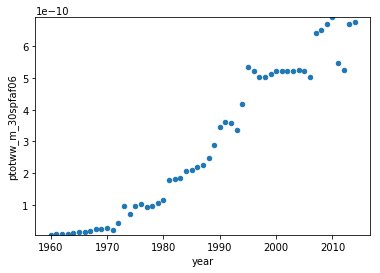

In [114]:
ax1 = df_raw.plot.scatter("year","ptotww_m_30spfaf06")
ax1.set_ylim(df_raw["ptotww_m_30spfaf06"].min(),df_raw["ptotww_m_30spfaf06"].max())

(0.0, 1.8562104020013099)

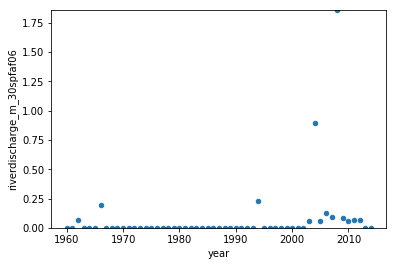

In [115]:
ax1 = df_raw.plot.scatter("year","riverdischarge_m_30spfaf06")
ax1.set_ylim(df_raw["riverdischarge_m_30spfaf06"].min(),df_raw["riverdischarge_m_30spfaf06"].max())

# Moving Average

In [116]:
def simplify_df_ma(df):
    df_out = df[["year","ma10_ptotww_m_30spfaf06","ma10_ptotwn_m_30spfaf06","ma10_riverdischarge_m_30spfaf06"]]
    return df_out

In [117]:
df_ma = simplify_df_ma(df_og)

In [118]:
df_ma.head()

,year,ma10_ptotww_m_30spfaf06,ma10_ptotwn_m_30spfaf06,ma10_riverdischarge_m_30spfaf06
0,1960,6.128679e-12,6.128679e-12,0.000000
1,1961,6.894763e-12,6.894763e-12,0.000000
2,1962,7.659453e-12,7.659453e-12,0.020964
3,1963,8.240645e-12,8.240645e-12,0.015768
4,1964,8.897067e-12,8.897067e-12,0.012615


In [119]:
df_ma = df_ma.sort_values(by=["year"])

(6.1286785555459597e-12, 6.09478412032819e-10)

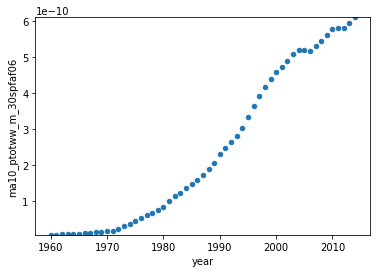

In [120]:
ax1 = df_ma.plot.scatter("year","ma10_ptotww_m_30spfaf06")
ax1.set_ylim(df_ma["ma10_ptotww_m_30spfaf06"].min(),df_ma["ma10_ptotww_m_30spfaf06"].max())

(0.0, 0.33748726067295298)

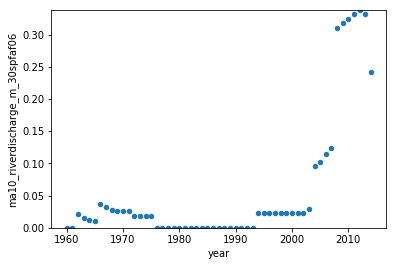

In [121]:
ax1 = df_ma.plot.scatter("year","ma10_riverdischarge_m_30spfaf06")
ax1.set_ylim(df_ma["ma10_riverdischarge_m_30spfaf06"].min(),df_ma["ma10_riverdischarge_m_30spfaf06"].max())

# Combined

In [122]:
from bokeh.plotting import figure 
from bokeh.io import output_notebook, show
from bokeh.models import HoverTool
import random
import bokeh.palettes

In [123]:
palette = bokeh.palettes.Category20

In [124]:
output_notebook()

Loading BokehJS ...

In [125]:
def plot(indicators,df_og,raw_values=True,ma10_values=True,ols_values=True):
    """ For a given basin, plots multiple results the same chart.    
    -------------------------------------------------------------------------------
    
    df_og can be obtained from table 
    y2018m06d01_rh_temporal_reducers_postgis_30spfaf06_v01_v01 in the postGreSQL
    Database
    
    maximum number of lines supported is 20 due to colorscheme.
    
    Args:
        indicators (list) : list of string of indicators. Use basenames.
            options include a.o. : ['ptotww','riverdischarge']
        df_og (pd.DataFrame) : DataFrame with values.
        raw_values (boolean) : Plot raw, monthly and yearly values.
            defaults to True.
        ma10_values (boolean) : Plot moving average values.
            defaults to True.
        ols_values (boolean) : Plot values based on regression.
            defaults to True.

    Returns:
        p (Bokeh Plot): Bokeh plot. Use show(p)
    
    """
    p = figure(width=900, height=800)
    
    number_of_lines = len(indicators)*(raw_values+ma10_values+ols_values)
    print(number_of_lines)
    
    i=0
    
    if raw_values:
        for indicator in indicators:
            p.line(x = df_og["year"], y = df_og[indicator+'_m_30spfaf06'],line_color=palette[number_of_lines][i],legend= indicator+"_m_30spfaf06")
            i += 1
    if ma10_values:
        for indicator in indicators:
            p.line(x = df_og["year"], y = df_og['ma10_'+indicator+'_m_30spfaf06'],line_color=palette[number_of_lines][i],legend="ma10_"+indicator+"_m_30spfaf06")
            i += 1
    if ols_values:
        for indicator in indicators:
            p.line(x = df_og["year"], y = df_og['ols10_'+indicator+'_m_30spfaf06'],line_color=palette[number_of_lines][i],legend="ols10_"+indicator+"_m_30spfaf06")
            i += 1
    p.legend.location = "top_left"
    p.legend.click_policy="hide"
    hover = HoverTool(tooltips = [('year', '@x'),
                             ('value',  '@y')])
    p.add_tools(hover)
    
    return p
    

In [126]:
sectors = ["dom","ind","irr","liv","tot"]
demand_types = ["ww","wn"]
supply = ["riverdischarge"]

indicators = []
for sector in sectors:
    for demand_type in demand_types:
        demand_column_name = "p{}{}".format(sector,demand_type)
        indicators.append(demand_column_name)
supply_column_names = ["{}".format(supply[0])]   
indicators = indicators + supply_column_names


In [127]:
indicators

['pdomww',
 'pdomwn',
 'pindww',
 'pindwn',
 'pirrww',
 'pirrwn',
 'plivww',
 'plivwn',
 'ptotww',
 'ptotwn',
 'riverdischarge']

In [128]:
indicators_filtered = ["ptotww","ptotwn","riverdischarge"]
#indicators_filtered = ["ptotww","pdomww","pindww","pirrww","plivww"]
#indicators_filtered = ["ptotwn","pdomwn","pindwn","pirrwn","plivwn"]
#indicators_filtered = ["ptotww","ptotwn","riverdischarge"]

In [129]:
# number of lines =< 20

p = plot(indicators_filtered,df_og,1,1,1)
show(p)

9


# Regression

there are multiple options for linear regression. 

1. Withdrawal and river discharge separately: Use a moving window of 10 years, perform ols regression and determine the final year for each window.
    Probably requires some thresholds for basins with a small number of valid years. (e.g. capped at max value, and minimum 0?)
1. Use a linear trend for demand and a moving average for riverdischarge






In [ ]:
sql_reg = ("SELECT year,month,pfafid_30spfaf06, temporal_resolution,ptotww_m_30spfaf06 "
"FROM y2018m05d29_rh_total_demand_postgis_30spfaf06_v01_v02 " 
"WHERE pfafid_30spfaf06 = 231607 "
"AND month = 5")

In [ ]:
df_reg = pd.read_sql(sql_reg,connection)

In [ ]:
df_reg = df_reg.sort_values(by=["year"])

In [ ]:
df_reg.head()

In [ ]:
lm = linear_model.LinearRegression()

In [ ]:
# Fit line for year 1973 - 1982 (10 years)
df_reg_selection = df_reg[(df_reg["year"] >= 1973) & (df_reg["year"] <= 1982)]

In [ ]:
df_reg_selection

In [ ]:
import os

In [ ]:
print(os.getcwd())

In [ ]:
df_reg_selection.to_csv("temp.csv")

In [ ]:
# fit linear model. 

In [ ]:
x = pd.DataFrame(df_reg_selection["year"])
target = pd.DataFrame(df_reg_selection["ptotww_m_30spfaf06"])

In [ ]:
lm.fit(x,target)

In [ ]:
df_lm = pd.DataFrame()

In [ ]:
coef = lm.coef_[0][0]

In [ ]:
intercept = lm.intercept_[0]

In [ ]:
# projected value for 1982
y_p = 1982*coef + intercept

In [ ]:
print(y_p,coef,intercept)

In [ ]:
def create_ols_query(ols_window,con,input_table_name,output_table_name,input_columns, ols_columns):
    """ Applies a moving average and saves the result in a new table. 
    -------------------------------------------------------------------------------
    
    Designed to work with aqueduct table structure that includes a year, month and
    temporal_resolution column. Will not work with other tables.     
    
    
    
    Args:
        ols_window (integer) : Ordinary Leas Squares Regression length.
        con (sqlAlchemy) : Database Connection. 
        input_table_name (string) : Input table name.
        output_table_name (string) : Output table name.
        input_columns (list) : list of column names used in the query and saved to
            output. e.g. year, month, pfafid etc. 
        mols_columns (list) : list of column names to apply the ols to.
            should be present in input table. 
    
    Returns:
        sql (string) : SQL string in postgreSQL dialect.
    
    
    """
    sql = "CREATE TABLE {} AS ".format(output_table_name)
    sql = sql + "SELECT"    
    for input_column in input_columns:
        sql = sql + " {},".format(input_column)
    for ols_column in ols_columns:
        sql = sql + " regr_slope({},year) OVER (PARTITION BY pfafid_30spfaf06, month, temporal_resolution ORDER BY year ROWS BETWEEN {:01.0f} PRECEDING AND CURRENT ROW) AS slope{:02.0f}_{},".format(ols_column,ols_window-1,ols_window,ols_column)
        sql = sql + " regr_intercept({},year) OVER (PARTITION BY pfafid_30spfaf06, month, temporal_resolution ORDER BY year ROWS BETWEEN {:01.0f} PRECEDING AND CURRENT ROW) AS intercept{:02.0f}_{},".format(ols_column,ols_window-1,ols_window,ols_column)
        sql = sql + (" regr_slope({},year) OVER (PARTITION BY pfafid_30spfaf06, month, temporal_resolution ORDER BY year ROWS BETWEEN {:01.0f} PRECEDING AND CURRENT ROW) * year "
                     "+ regr_intercept({},year) OVER (PARTITION BY pfafid_30spfaf06, month, temporal_resolution ORDER BY year ROWS BETWEEN {:01.0f} PRECEDING AND CURRENT ROW) AS ols{:02.0f}_{},".format(ols_column,ols_window-1,ols_column,ols_window-1,ols_window,ols_column))
    sql = sql[:-1]
    sql = sql + " FROM {}".format(input_table_name)
    return sql
    

In [ ]:
input_columns = ["pfafid_30spfaf06",
                 "temporal_resolution",
                 "year",
                 "month",
                 "area_m2_30spfaf06",
                 "area_count_30spfaf06"]

In [ ]:
sectors = ["dom","ind","irr","liv","tot"]
demand_types = ["ww","wn"]
supply = ["riverdischarge"]

demand_column_names = []
for sector in sectors:
    for demand_type in demand_types:
        demand_column_name = "p{}{}_m_30spfaf06".format(sector,demand_type)
        demand_column_names.append(demand_column_name)
supply_column_names = ["{}_m_30spfaf06".format(supply[0])]
ols_columns = demand_column_names + supply_column_names
ols_columns

In [ ]:
sql = create_ols_query(ols_window=10,
                       con=connection,
                       input_table_name='y2018m05d29_rh_total_demand_postgis_30spfaf06_v01_v02',
                       output_table_name= "test01",
                       input_columns = input_columns,
                       ols_columns=ols_columns)

In [ ]:
sql = sql + " WHERE pfafid_30spfaf06 = 231607 AND month = 5"

In [ ]:
print(sql)

In [ ]:
# check if I can accomplish the same using SQL
SELECT year,month,pfafid_30spfaf06, temporal_resolution,ptotww_m_30spfaf06,
    regr_slope(ptotww_m_30spfaf06,year) 
        OVER (PARTITION BY pfafid_30spfaf06, month, temporal_resolution ORDER BY year ROWS BETWEEN 9 PRECEDING AND CURRENT ROW) AS slope
FROM y2018m05d29_rh_total_demand_postgis_30spfaf06_v01_v02 
WHERE year > 1970 AND
year < 1983 AND
year > 1972 AND
month = 5 AND
temporal_resolution = 'month'AND
pfafid_30spfaf06 = 231607